## Run the block of code below to get everything set up, including loading in the data into the notebook environment


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy

# Figure Settings
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Retrieve the data

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)

## Load in the data frame, and look at the first 5 values

In [ ]:
df = pd.read_csv("data01_direction4priors.csv")
df.tail()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
83208,198,571.895796,47.0,205,0.06,-0.895369,-2.334162,1.298565,574.493754,40,225,12,data01_direction4priors,12,6,30
83209,199,574.708207,238.0,265,0.12,-1.915175,-1.606893,1.175129,577.181812,40,225,12,data01_direction4priors,12,6,30
83210,200,577.408906,300.0,245,0.06,-0.076489,-2.498830,0.793728,579.492137,40,225,12,data01_direction4priors,12,6,30
83211,201,579.720922,10.0,185,0.12,0.177676,-2.493678,1.363531,582.373810,40,225,12,data01_direction4priors,12,6,30
83212,202,582.602137,33.0,185,0.06,-1.507874,-1.994070,1.553555,585.445742,40,225,12,data01_direction4priors,12,6,30


### Take the cartesian coordinates `estimate_x` and `estimate_y` and convert them into an `estimate_angle`. Additionally, calculate the difference between the `estimate_angle` and the true `motion_direction`, call this `absolute_angular_error`

# TODO: Fix error calculations so that it handles circular data; i.e., the DV being degrees


In [ ]:
# Convert cartesian coordinates to radians, then convert to degrees
df['estimate_angle'] = np.degrees(np.arctan2(df['estimate_y'], df['estimate_x']))

# Normalize the angle to be in the range of [0, 360)
df['estimate_angle'] = df['estimate_angle'] % 360

# Calculate the absolute angular error between the participant estimate,
#           and the motion direction of the stimulus
df['absolute_angular_error'] = np.abs(df['estimate_angle'] - df['motion_direction'])

# Look at header, again
df.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id,estimate_angle,absolute_angular_error
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,225.583113,0.583113
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,223.291282,1.708718
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,231.312691,3.687309
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,230.166776,5.166776
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,229.020860,14.020860


### Create a scatterplot of motion direction vs. estimate angle for each level of coherence

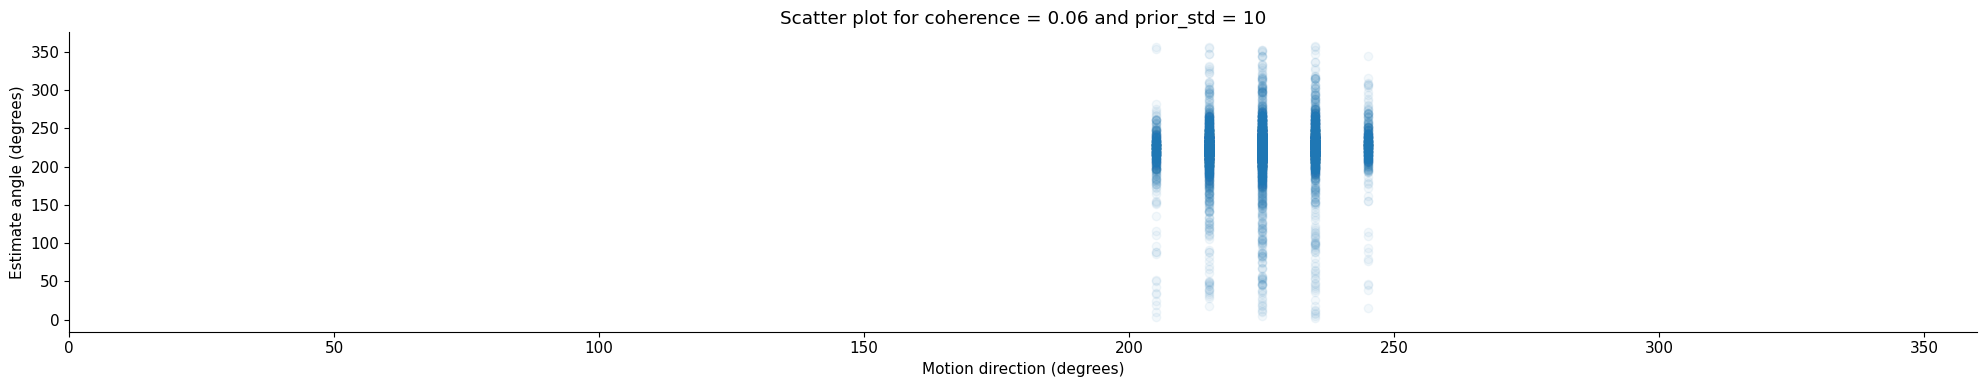

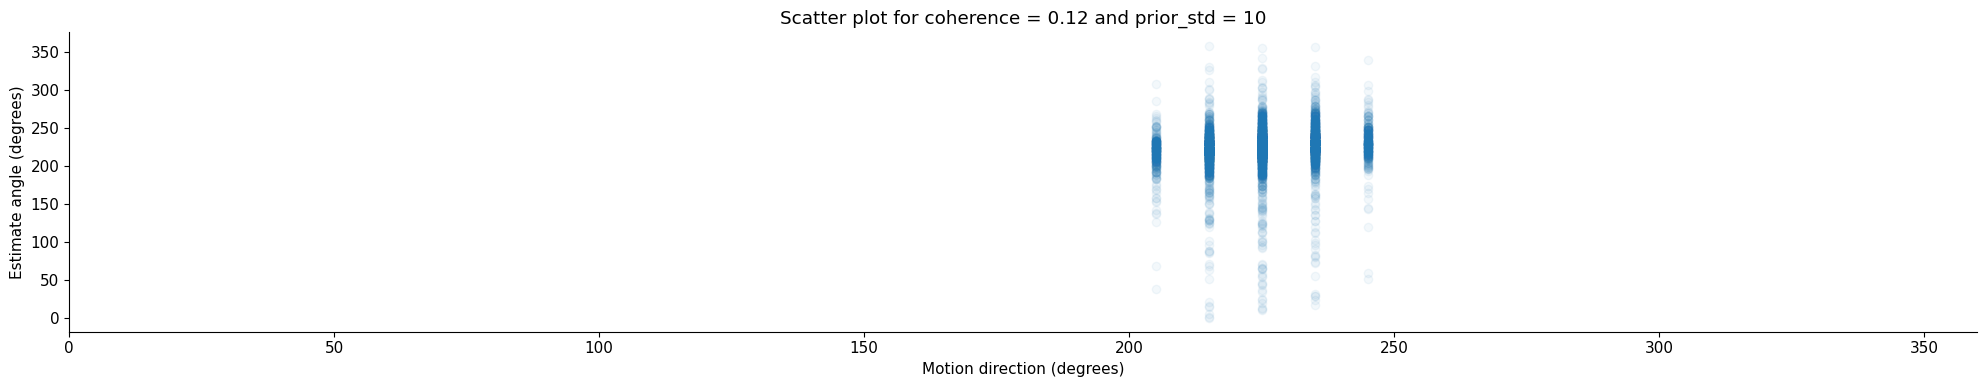

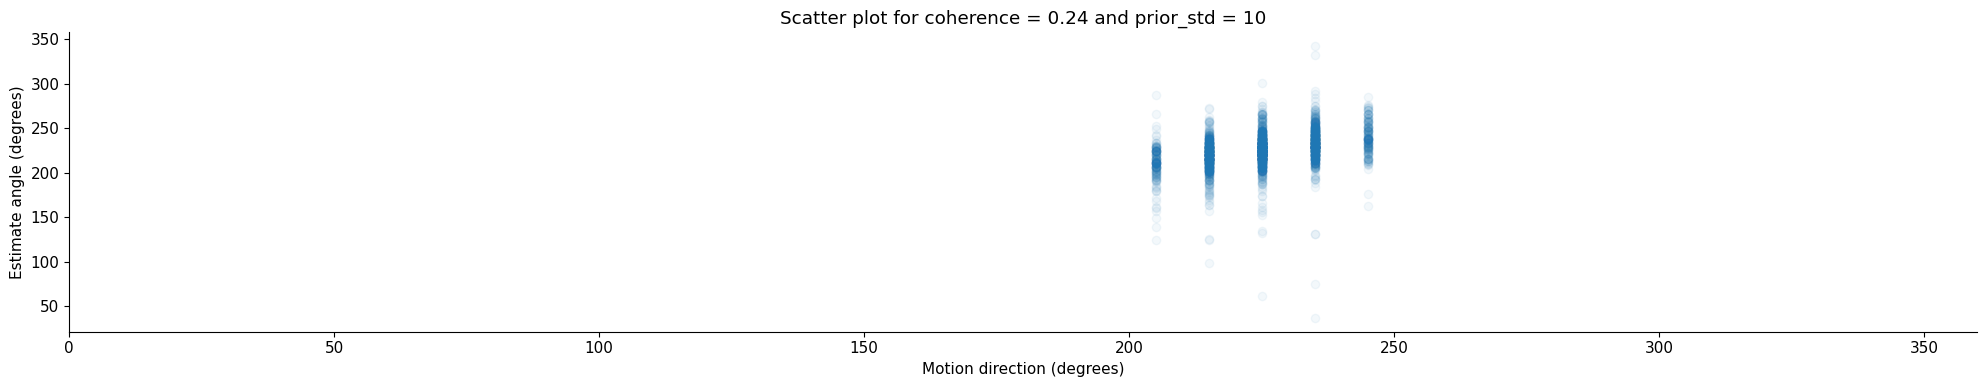

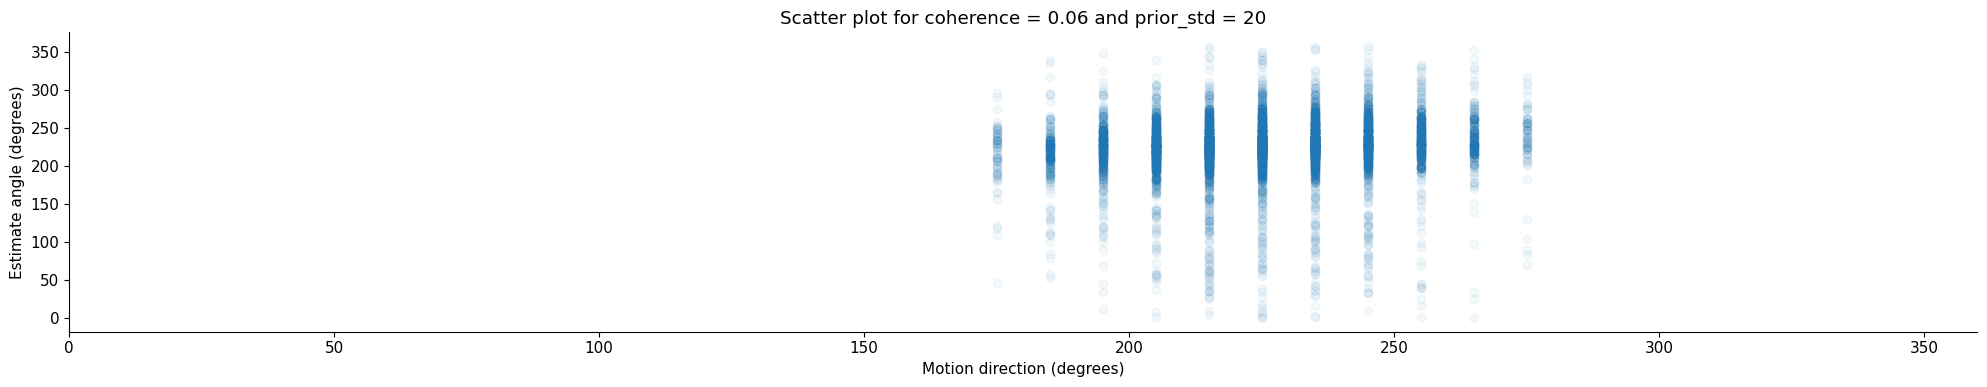

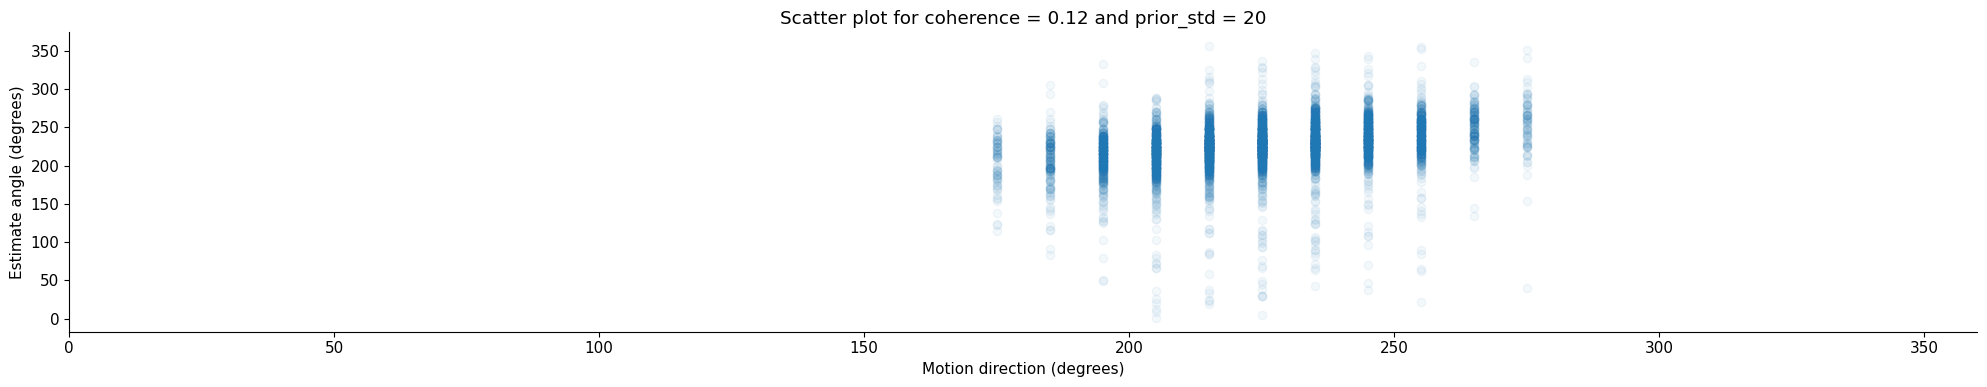

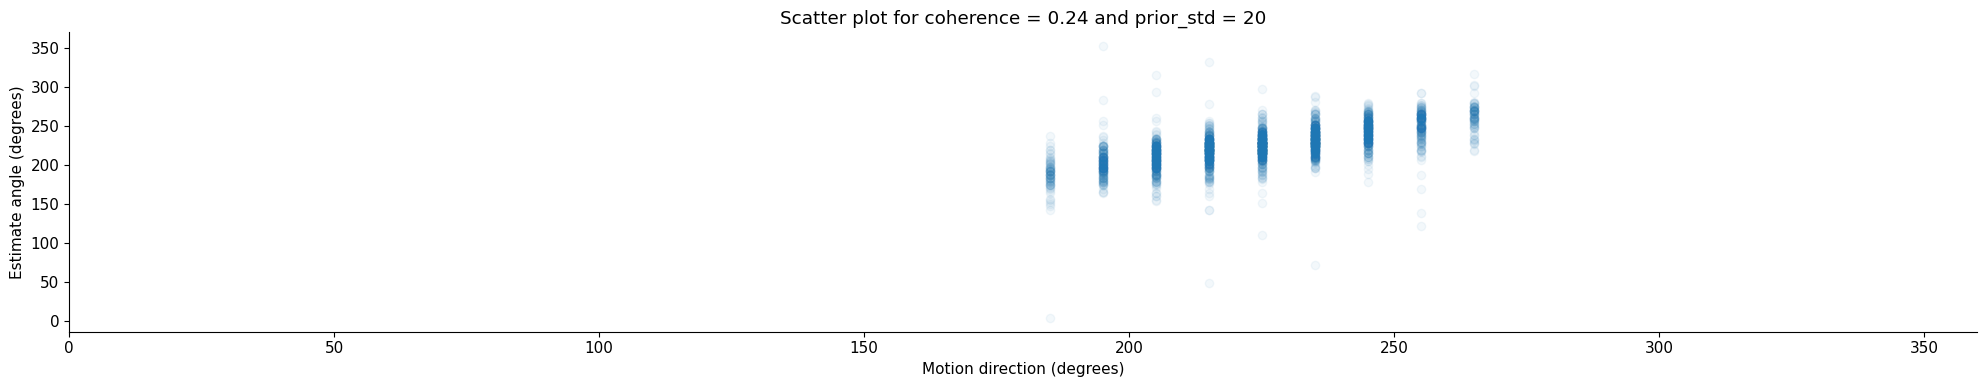

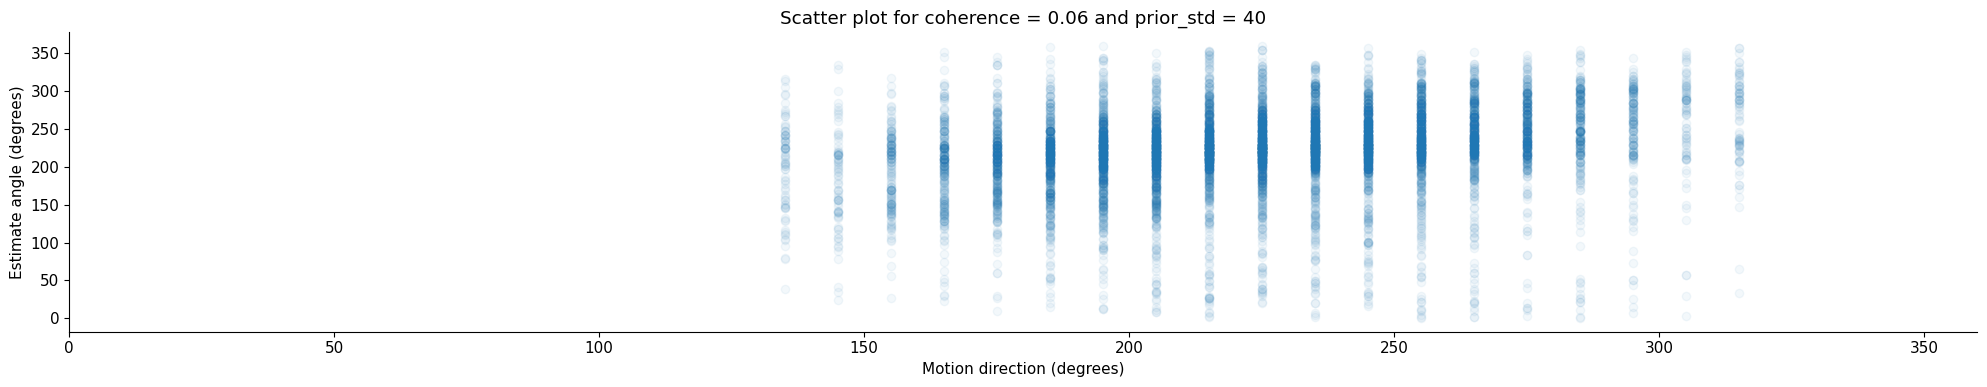

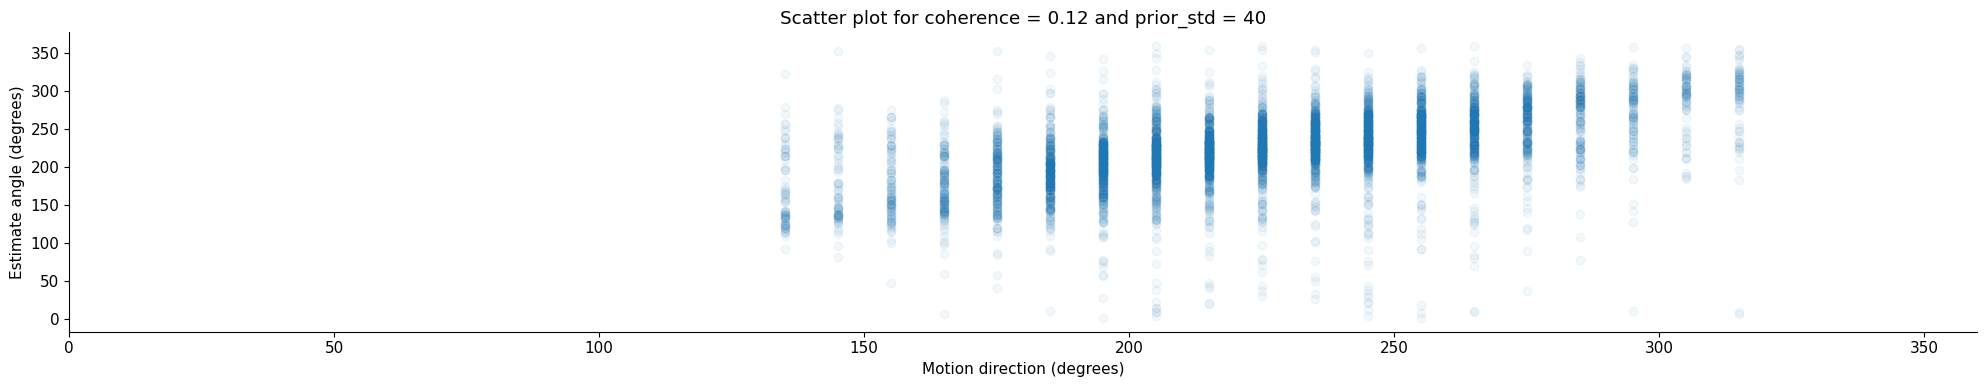

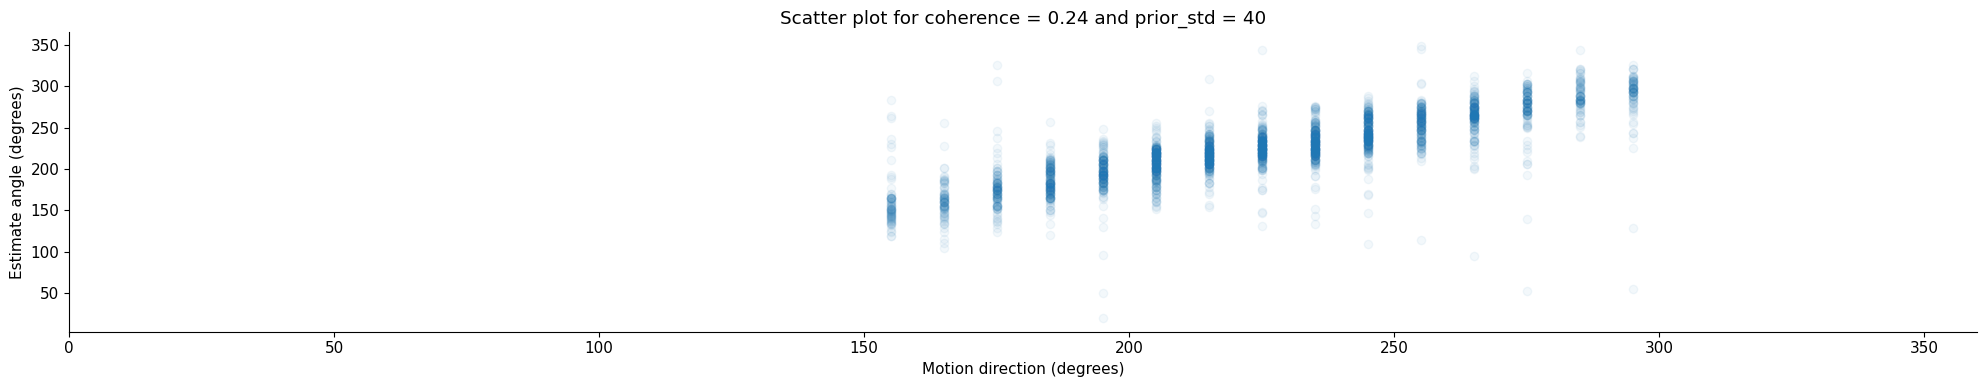

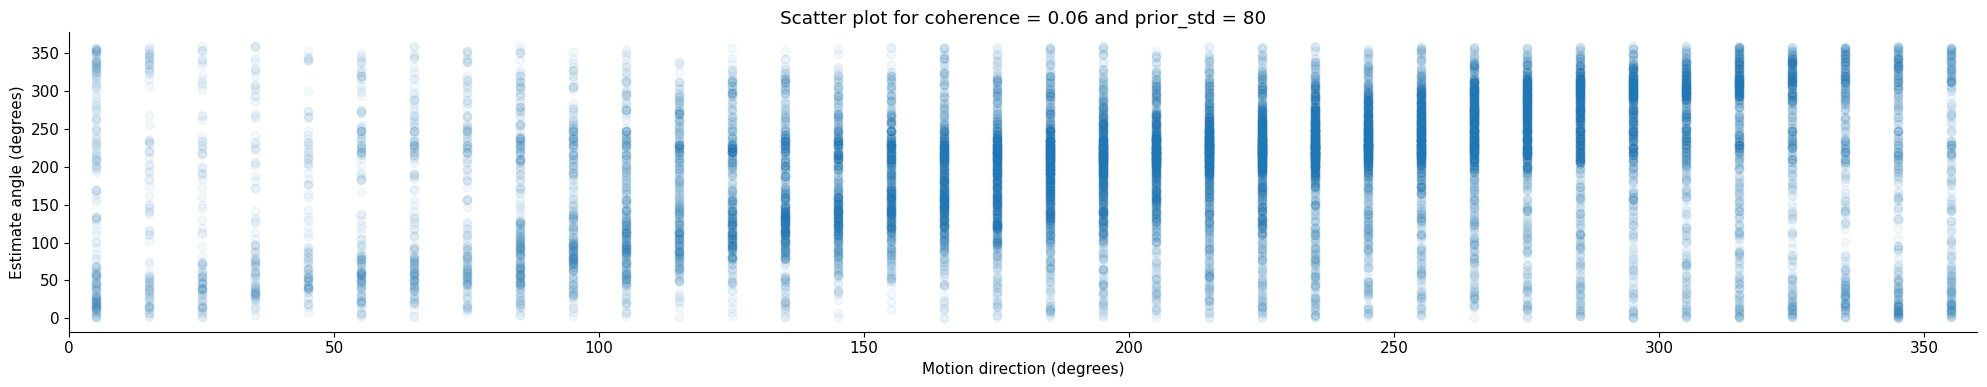

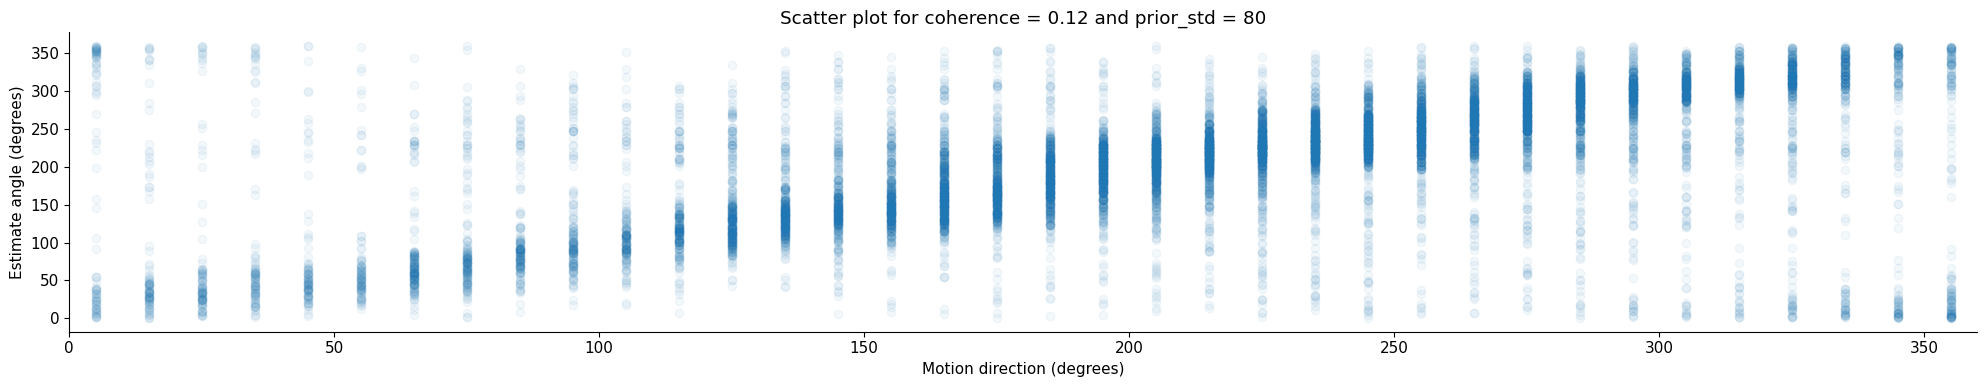

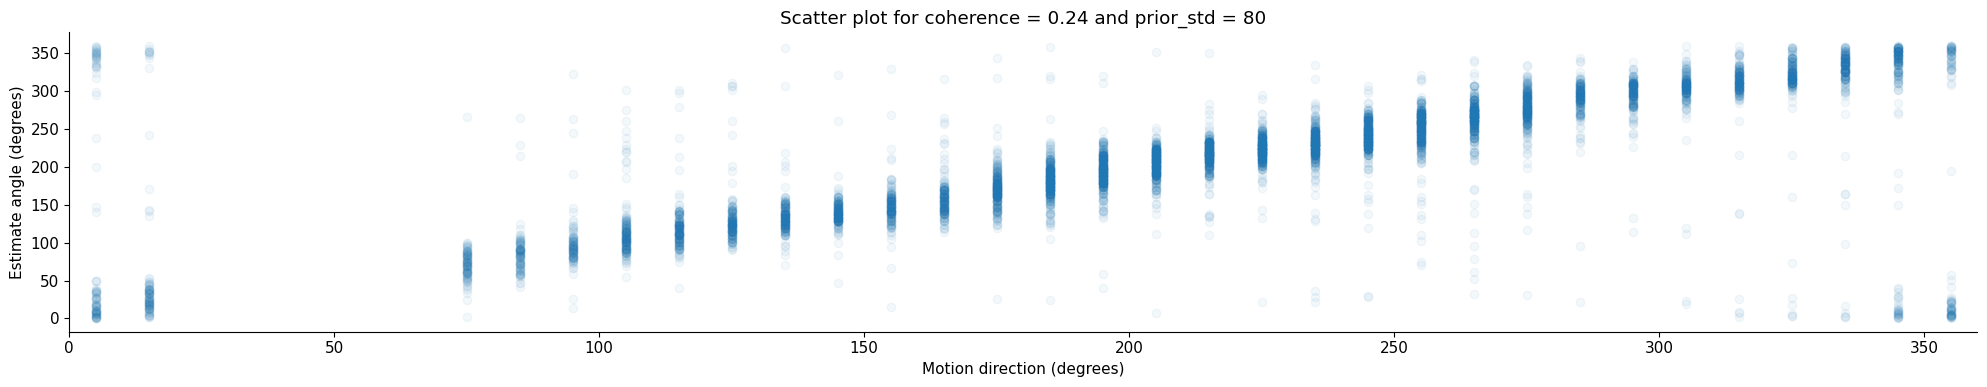

In [ ]:
import matplotlib.pyplot as plt

coherences = sorted(df['motion_coherence'].unique())
prior_standard_deviations = sorted(df['prior_std'].unique())

for prior_std in prior_standard_deviations:
    for coherence in coherences:
        # Filter the DataFrame for both coherence and prior_std
        df_subset = df[(df['motion_coherence'] == coherence) & (df['prior_std'] == prior_std)]

        # Check if the subset is not empty
        if not df_subset.empty:
            plt.scatter(df_subset['motion_direction'], df_subset['estimate_angle'], alpha=0.05)
            plt.xlabel('Motion direction (degrees)')
            plt.ylabel('Estimate angle (degrees)')
            plt.title(f'Scatter plot for coherence = {coherence} and prior_std = {prior_std}')
            plt.xlim(0, 360)  # Set x-axis limits to be from 0 to 360
            plt.show()
        else:
            print(f"No data available for coherence = {coherence} and prior_std = {prior_std}")

## Trent Messing around with neural nets...

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class RingNetwork(nn.Module):
    def __init__(self, num_neurons, input_size):
        super(RingNetwork, self).__init__()
        self.num_neurons = num_neurons
        self.input_layer = nn.Linear(input_size, num_neurons)
        self.neuron_layer = nn.Linear(num_neurons, num_neurons)
        self.output_layer = nn.Linear(num_neurons, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        # Emulate ring connection by cycling through the neuron layer multiple times
        for _ in range(self.num_neurons):
            x = self.activation(self.neuron_layer(x))
        x = self.output_layer(x)
        return x

# Example Usage
num_neurons = 20
input_size = 3

model = RingNetwork(num_neurons, input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Dummy data for demonstration
inputs = torch.rand(100, 3)
targets = torch.rand(100, 1) * 359  # Scale targets between 0 and 359

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Testing the model
test_input = torch.tensor([0.5, 0.1, 0.2])
predicted_output = model(test_input)
print("Predicted Output:", predicted_output.item())

Epoch 0, Loss: 40400.33203125
Epoch 100, Loss: 32921.421875
Epoch 200, Loss: 26906.517578125
Epoch 300, Loss: 22295.419921875
Epoch 400, Loss: 18719.53515625
Epoch 500, Loss: 15980.365234375
Epoch 600, Loss: 13922.6201171875
Epoch 700, Loss: 12413.0625
Epoch 800, Loss: 11335.3388671875
Epoch 900, Loss: 10588.8662109375
Predicted Output: 147.92039489746094


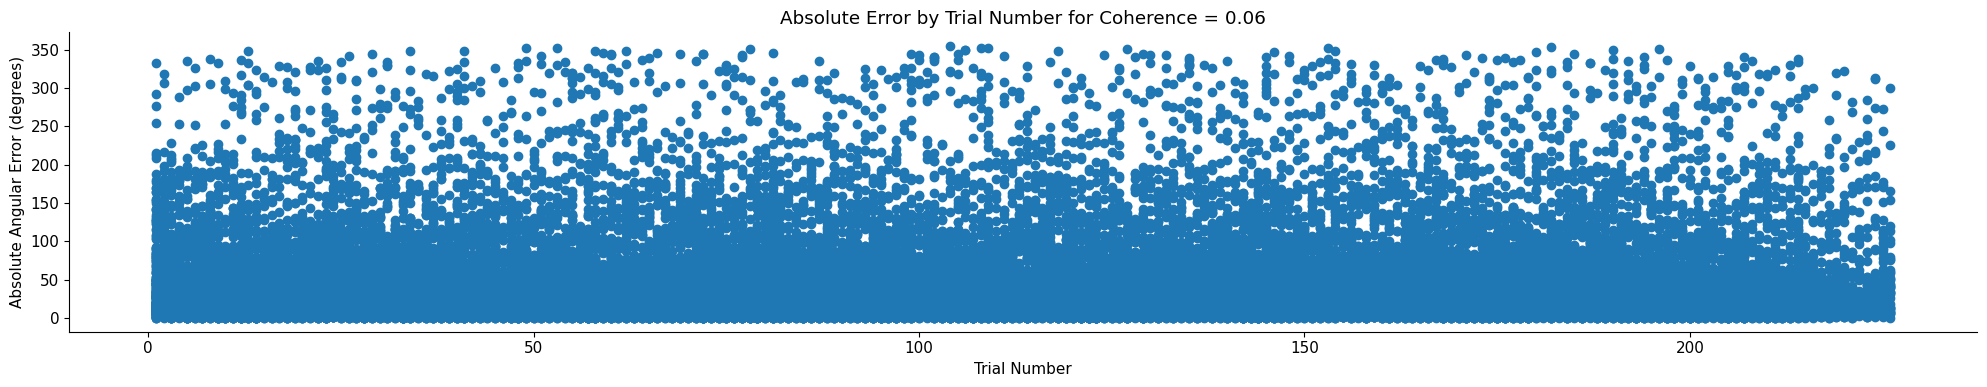

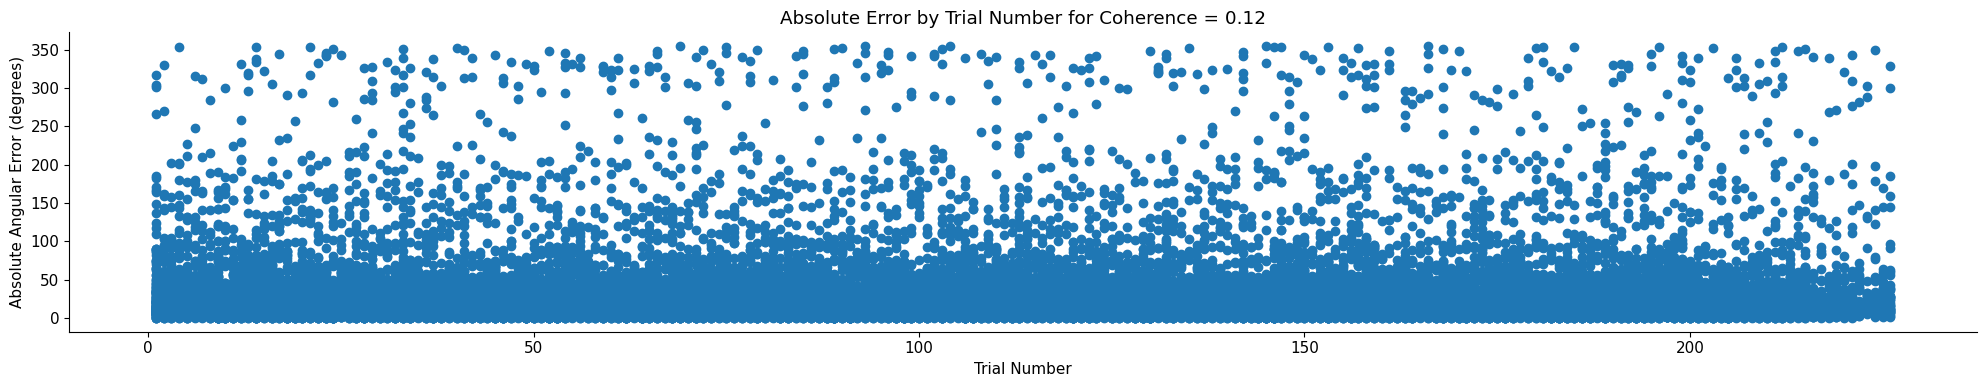

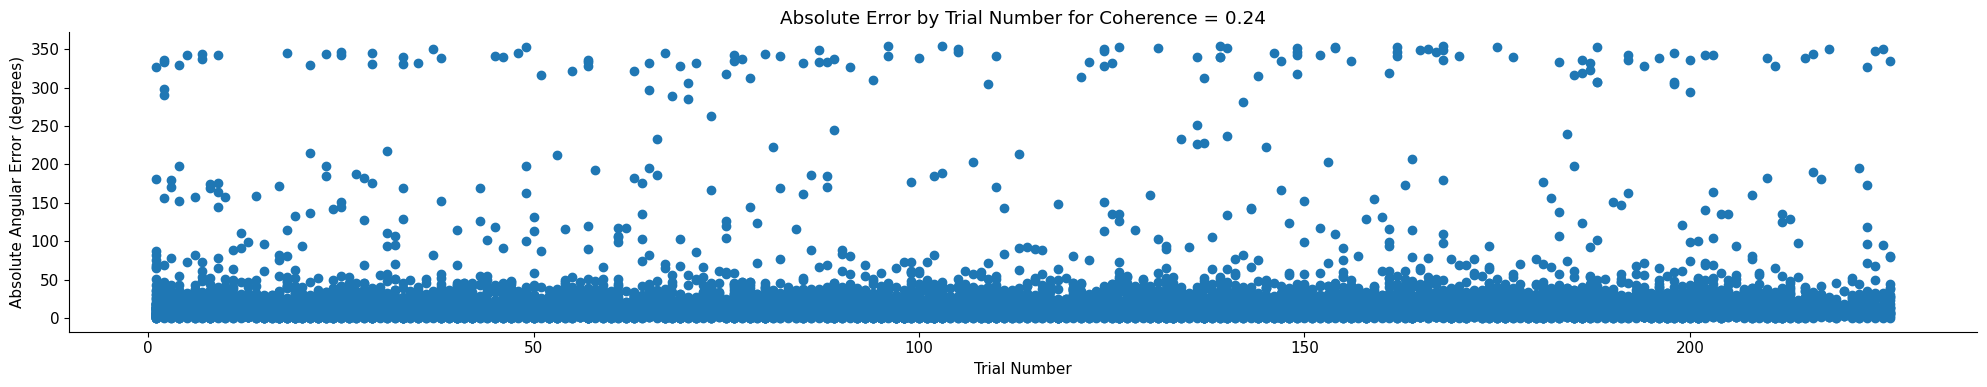

In [ ]:
# Extract relevant data from the DataFrame
coherences = sorted(df['motion_coherence'].unique())
trial_numbers = df['trial_index']
absolute_errors = df['absolute_angular_error']

# Loop through each coherence level
for coherence in coherences:
    # Filter data for the current coherence level
    coherence_data = df[df['motion_coherence'] == coherence]

    # Create the scatter plot
    plt.scatter(coherence_data['trial_index'], coherence_data['absolute_angular_error'])
    plt.xlabel('Trial Number')
    plt.ylabel('Absolute Angular Error (degrees)')
    plt.title(f'Absolute Error by Trial Number for Coherence = {coherence}')
    plt.show()
